In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 
import pingouin as pg

%matplotlib inline

OUTDATED_IGNORE=1

In [2]:
df = pd.read_csv('dating_data.csv')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
df.shape

(14514, 4)

так как цель нашего приложения -- дать людям познакомиться, будем брать за целевую метрику коэф. состоявшихся мэтчей

в качестве прокси метрики возьмем количество попыток мэтчей на юзера

In [5]:
# создаем отдельные дф для контрольной и тестовой групп

control = df[df.group == 0] 
test = df[df.group == 1]

чтобы не писать для каждого дф отдельно группировку и агрегацию, засовываем это в функцию

для каждого пользователя считаем кол-во строк (это будут попытки мэтчей) и сумму мэтчей
из этой информации создаем коэффициент успешности мэтчей (сумма мэтчей на сумму попыток)



In [6]:
def make_aggregated(df):
    
    df = df.groupby(['user_id_1'], as_index=False) \
        .agg({'group':'count', 'is_match':'sum'}) \
        .rename(columns = {'group':'attempts', 'is_match':'matches', 'user_id_1':'user_id'}) 
    df['match_rate'] = (df.matches / df.attempts).round(3)

    return df

In [62]:
test_agg = get_match_rate(test)

In [63]:
test_agg.head()

,user_id,attempts,matches,match_rate
0,1,24,11,0.458
1,2,16,7,0.438
2,3,16,5,0.312
3,5,22,13,0.591
4,6,22,9,0.409


In [64]:
control_agg = get_match_rate(control)

In [65]:
control_agg.head()

,user_id,attempts,matches,match_rate
0,4,9,2,0.222
1,10,6,3,0.500
2,12,12,1,0.083
3,14,8,0,0.000
4,15,20,3,0.150


In [ ]:
# в следующих двух графиках смотрим на распределение коэф. успешности

# и невооруженным глазом, и с помощью теста видно, что в контрольной группе распределение метрики ненормальное,
# поэтому имеет смысл использовать непараметрический тест и/или бутстреп (я буду использовать оба, почему нет)

,W,pval,normal
match_rate,0.95725,7.120411e-11,False


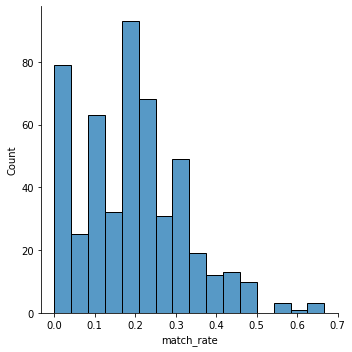

In [112]:
sns.displot(data=control_agg, x=control_agg.match_rate)

pg.normality(control_agg.match_rate)

,W,pval,normal
match_rate,0.996023,0.243507,True


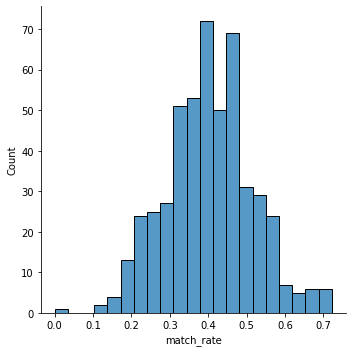

In [111]:
sns.displot(data=test_agg, x=test_agg.match_rate)

pg.normality(test_agg.match_rate)

In [ ]:
sns.displot()

так же как в прошлом шаге, чтобы не писать одно и то же несколько раз, делаем функцию для рассчета стат. тестов будем использовать непарам. критерий манна-уитни, но т.к. он не очень хорошо подходит для сравнения средних, рискнем и проверим себя с помощью т-критерий

из полученных выводов из тестов делаем дф, чтобы все было красиво и в одном месте 

колонка greater -- p-value того, что значения тестовой группы больше контрольной, lesser -- обратное



In [97]:
def get_p_values(data_1, data_2):
    
    d = {
        'greater':  [
            pg.mwu(data_1, data_2, alternative='greater')['p-val'].values[0],
            pg.ttest(data_1, data_2, alternative='greater')['p-val'].values[0]
        ],
        'lesser': [
            pg.mwu(data_1, data_2, alternative='less')['p-val'].values[0],
            pg.ttest(data_1, data_2, alternative='less')['p-val'].values[0]   
        ]
    }
    
    df = pd.DataFrame(data = d, index=['MWU','T-test'])
    
    return df

чтобы не загромождать предыдущую функцию, сделаем отдельный дф и функцию для рассчета интервалов

бутстреп используем, т.к. оба используемых ранее критерия могут выдавать ошибки в нашем случае

колонка higher -- верхняя граница интервала, lower -- нижняя



In [104]:
def get_intervals(data_1, data_2):
    
    d = {
         'higher': [
            stats.bootstrap((data_1, ), np.median, method='basic').confidence_interval[1],
            stats.bootstrap((data_2, ), np.median, method='basic').confidence_interval[1]
         ],
         'lower': [
            stats.bootstrap((data_1, ), np.median, method='basic').confidence_interval[0],
            stats.bootstrap((data_2, ), np.median, method='basic').confidence_interval[0]
         ]
    }
        
    df = pd.DataFrame(data = d, index=['control','test'])
    
    return df

In [120]:
matches_p_val = get_p_values(test_agg.match_rate, control_agg.match_rate)

p-value по обоим тестам вышли мизерные, так что можем сделать (предварительный) вывод, что значения в тестовой группе больше, чем в контрольной



In [121]:
matches_p_val

,greater,lesser
MWU,5.369643e-97,1.0
T-test,9.935199e-117,1.0


In [107]:
matches_intervals = get_intervals(control_agg.match_rate, test_agg.match_rate)

доверительные интервалы из бутстрепа у нас тоже не пересекаются, что дополнительно подтверждает вывод



In [108]:
matches_intervals

,higher,lower
control,0.197,0.164
test,0.400,0.388


далее проводим ту же самую операцию для попыток мэтчей

так как оба распределения ненормальные, тесты из предыдущих шагов нам пригодятся

,W,pval,normal
attempts,0.988484,0.000557,False


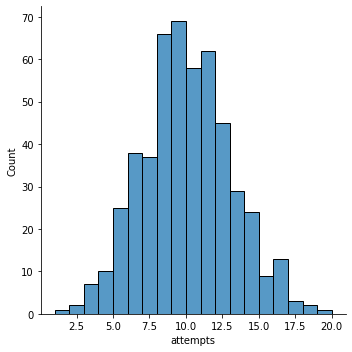

In [113]:
sns.displot(control_agg, x=control_agg.attempts)

pg.normality(control_agg.attempts)

,W,pval,normal
attempts,0.983929,0.000025,False


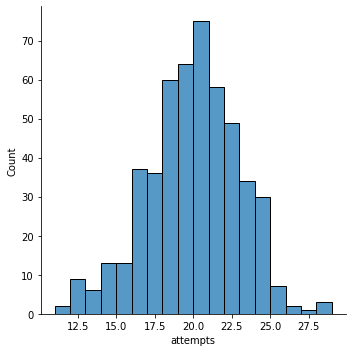

In [114]:
sns.displot(test_agg, x=test_agg.attempts)

pg.normality(test_agg.attempts)

In [122]:
attempts_p_val = get_p_values(test_agg.attempts, control_agg.attempts)

по прокси метрике такой же результат, как по целевой, попытки мэтчей на юзера тоже выросли в тестовой группе 



In [123]:
attempts_p_val

,greater,lesser
MWU,3.452577e-157,1.0
T-test,1.002684e-285,1.0


In [118]:
attempts_intervals = get_intervals(control_agg.attempts, test_agg.attempts)

интервалы тоже подтверждают наш вывод



In [119]:
attempts_intervals

,higher,lower
control,9.0,8.0
test,21.0,20.0


### заключение:

в ходе исследования данных приложения были выявлены статистически значимые различия между контрольной и тестовой группами пользователей в a/b тесте

по целевой метрике -- коэффициенту успешных мэтчей, как и по прокси-метрике -- кол-ву попыток мэтчей, различия были в пользу тестовой группы, так что можно выкатывать новый алгоритм